In [1]:
import geemap
import pandas as pd
import numpy as np
import pdb
from IPython.display import display
import ee
import os

In [106]:
#Load from csv:
ulti_log = pd.read_csv('~F:/Iowa BMP/mosaic_elevation.csv')

ulti_log

C:\Users\arj26323\AppData\Local\Temp\ipykernel_2124\3187623219.py:2: DtypeWarning: Columns (5,8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ulti_log = pd.read_csv('~F:/Iowa BMP/mosaic_elev_small.csv')


,index,HUC_12,NRCS_CODE,PRACTICE,Present2_1,CREATOR_NA,Present80s,SHAPE_Area,LAST_EDIT_,Merge,...,imagedate,G,N,Shape_Leng,ORIG_FID,Shape_Area,BUFF_DIST,CID,ndvi,ndwi
0,0,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,20100829,86,160,NaN,NaN,NaN,NaN,NaN,0.367521,-0.300813
1,1,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,20100829,76,127,NaN,NaN,NaN,NaN,NaN,0.322917,-0.251232
2,2,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,20100829,76,127,NaN,NaN,NaN,NaN,NaN,0.322917,-0.251232
3,3,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,20100829,81,135,NaN,NaN,NaN,NaN,NaN,0.310680,-0.250000
4,4,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,20100829,88,148,NaN,NaN,NaN,NaN,NaN,0.333333,-0.254237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431288,4995,NaN,NaN,Farmland,NaN,NaN,NaN,NaN,NaN,NaN,...,20100813,112,134,0.066038,100.0,0.000337,1000.0,0.0,0.229358,-0.089431
431289,4996,NaN,NaN,Farmland,NaN,NaN,NaN,NaN,NaN,NaN,...,20100813,112,134,0.066038,100.0,0.000337,1000.0,0.0,0.229358,-0.089431
431290,4997,NaN,NaN,Farmland,NaN,NaN,NaN,NaN,NaN,NaN,...,20100813,123,149,0.066038,100.0,0.000337,1000.0,0.0,0.201613,-0.095588
431291,4998,NaN,NaN,Farmland,NaN,NaN,NaN,NaN,NaN,NaN,...,20100813,112,130,0.066038,100.0,0.000337,1000.0,0.0,0.176471,-0.074380


In [117]:
# #Add NDVI and NDWI - until you can get addbands functions to work with extraction
# ulti_log['ndvi'] = (ulti_log['N']-ulti_log['R'])/(ulti_log['N']+ulti_log['R'])
# ulti_log['ndwi'] = (ulti_log['G']-ulti_log['N'])/(ulti_log['G']+ulti_log['N']) #not making use of SWIR

#add other indices?

# Get the labeled training data for each band
red_train = ulti_log['R']
blue_train = ulti_log['B'] ##WHY DOES THIS WORK FOR MOSAIC BUT NOT FOR NON MOSAIC
green_train = ulti_log['G']
nir_train = ulti_log['N']
ndwi_train = ulti_log['ndvi']
ndvi_train = ulti_log['ndwi']

elev_train = ulti_log['elevation']

xargs = np.column_stack((blue_train, green_train, red_train, nir_train, ndvi_train, ndwi_train, elev_train)) 
##ORDER OF XARGS MATTERS

# # Get the labeled value
yargs = ulti_log['PRACTICE']

seed = 3

# Split to training and test data
from sklearn.model_selection import train_test_split
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=0.2, random_state=seed)

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

'''
##LOOK INTO THIS: 
https://scikit-learn.org/stable/modules/generated/sklearn.
model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
'''

#Random forest classification
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('forest', RandomForestClassifier(n_estimators = 100, min_samples_leaf=10, random_state=seed))
    ]
)

pipe.fit(xargs_train, yargs_train) #Train
y_pred=pipe.predict(xargs_test) #Fit the testing data

In [119]:
#Model results
print(accuracy_score(yargs_test, y_pred))
print(confusion_matrix(yargs_test, y_pred)) 
#Why are there such low sample sizes for some of the features? The lowest pixel count is over 14,000, for pond dam

0.865161896149967
[[ 2326   419   120     1     0    78    24]
 [    6 48795   347    18    17    90    27]
 [   44  2290 12858    68    10   284    90]
 [   40  1449   409  1004     4   198    69]
 [    2   115    36     1   652     7     2]
 [   34  1816   753    62    12  6348   201]
 [   68  1348   552    43    22   455  2645]]


In [120]:
sum(confusion_matrix(yargs_test, y_pred)) #why are these numbers so #172231 total

array([ 2520, 56232, 15075,  1197,   717,  7460,  3058], dtype=int64)

In [121]:
yargs_test

400576            Farmland
313007            Farmland
229198            Farmland
430580            Farmland
199506            Farmland
                ...       
113939             Terrace
102984    Grassed Waterway
142237             Terrace
383540            Farmland
184386       Stripcropping
Name: PRACTICE, Length: 86259, dtype: object

In [122]:
df = ulti_log.groupby('PRACTICE')['imagedate'].count() #'index' not present in farmland extraction

df #i have concerns stripcropping is not getting data from enough locations - also pond dam seems low? see gis file

PRACTICE
Contour Buffer Strips                         15000
Farmland                                     245000
Grassed Waterway                              79548
Pond Dam                                      15725
Stripcropping                                  4000
Terrace                                       46047
Water and Sediment Control Basin (WASCOB)     25973
Name: imagedate, dtype: int64

In [113]:
#Export df to csv, to save time

import os

out_dir = os.path.expanduser('~F:/Iowa BMP/')
out_csv = os.path.join(out_dir, 'mosaic_bands.csv')
# ulti_log.to_csv(out_csv, index = False)

bands: 7
height: 326
width: 332
crs: EPSG:26915


<closed DatasetReader name='F:/Iowa BMP/Geotiffs/IA/Tests/ia_im.tif' mode='r'>

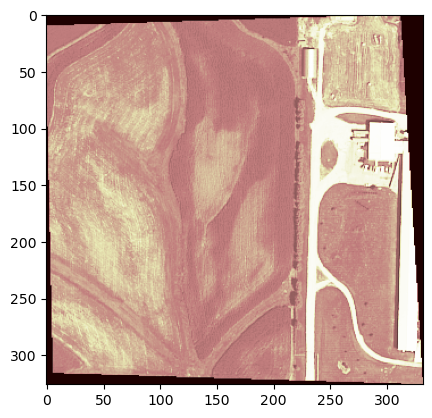

In [123]:
#Rasterio load geotiffs

import rasterio
import gdal

im = rasterio.open("F:/Iowa BMP/Geotiffs/IA/Tests/ia_im.tif")

print('bands: ' + str(im.count))
print('height: ' + str(im.height))
print('width: ' + str(im.width))
print('crs: ' + str(im.crs))

from matplotlib import pyplot as plt
from rasterio.plot import show

plt.imshow(im.read(1), cmap='pink')
# show(im)

input_tiff_path = "F:/Iowa BMP/Geotiffs/IA/Tests/ia_im.tif"
with rasterio.open(input_tiff_path) as src:
    red_band = src.read(1)
    green_band = src.read(2)
    blue_band = src.read(3)
    nir_band = src.read(4)
    
    ndvi_band = src.read(5)
    
    ndwi_band = src.read(6)
    
    elev_band = src.read(7) ##NOTE POSITION OF BANDs

    
# im.descriptions = tuple(['Blue', 'Green', 'Red', 'NIR','NDVWI','NDVI','ELEVATION']) - is this order correct?

src

In [124]:
'''
im band designations (NEED TO BE IN THIS ORDER, how the model was trained. CHECK FOR EVERY IMAGE): 
1: blue
2: green
3: red
4: nir
5: ndvi (added)
6: nd2i (added)
7: elevation (added)
'''

im_whole = np.column_stack(
    (
        im.read(1).ravel(), ##Blue
        im.read(2).ravel(), ##Green
        im.read(3).ravel(), ##Red
        im.read(4).ravel(), ##NIR
        im.read(5).ravel(), ##NDVI
        im.read(6).ravel(), ##NDWI
        im.read(7).ravel()  ##ELEVATION
                           )
) 

classified_labels = pipe.predict(im_whole)
classified_labels_reshaped = classified_labels.reshape(im.read(1).shape)

class_mapping = {
    'Terrace': 1,
    'Contour Buffer Strips': 2, 
    'Farmland': 3,
    'Grassed Waterway': 4, 
    'Pond Dam': 5, 
    'Stripcropping': 6,
    'Water and Sediment Control Basin (WASCOB)': 7
}

classified_labels_numeric = np.vectorize(class_mapping.get)(classified_labels_reshaped)

C:\Users\arj26323\AppData\Local\Temp\ipykernel_2124\3728095635.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([key for key in class_mapping.keys()])  # Set custom tick labels for the colorbar


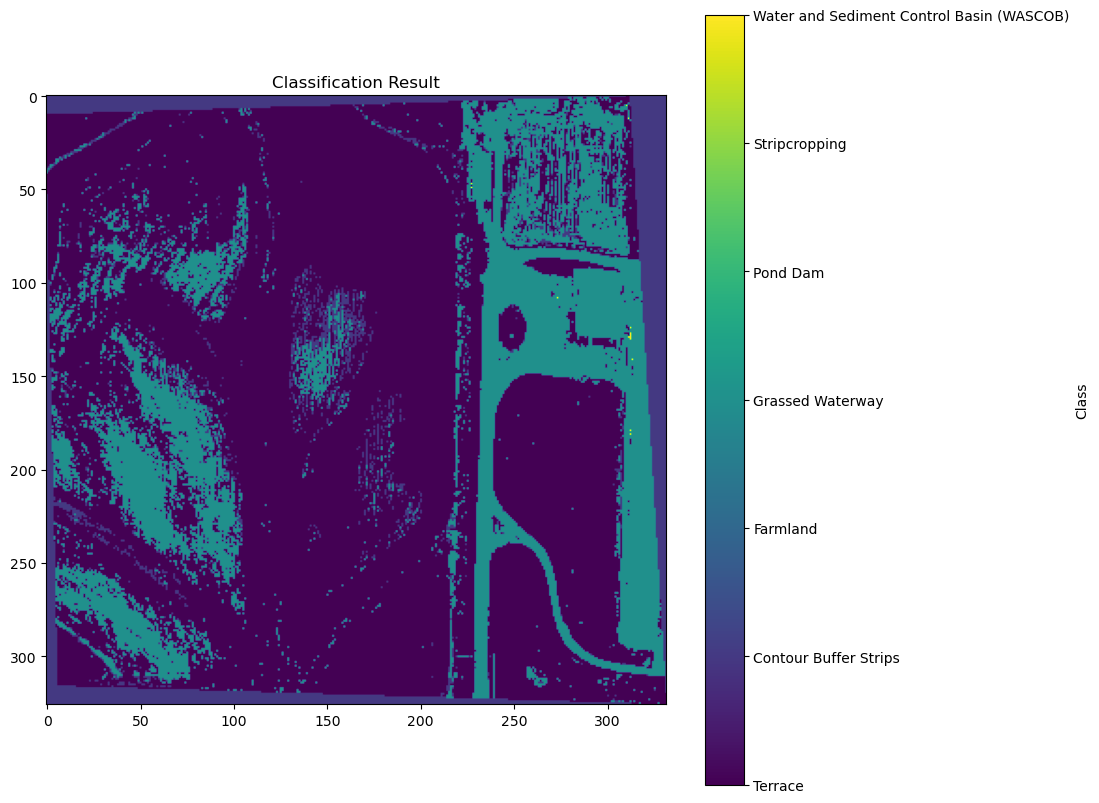

In [125]:
plt.figure(figsize=(10, 10))
plt.imshow(classified_labels_numeric, cmap='viridis')  # Choose a suitable colormap
cbar = plt.colorbar(label='Class')
cbar.ax.set_yticklabels([key for key in class_mapping.keys()])  # Set custom tick labels for the colorbar
plt.title('Classification Result')
plt.show()

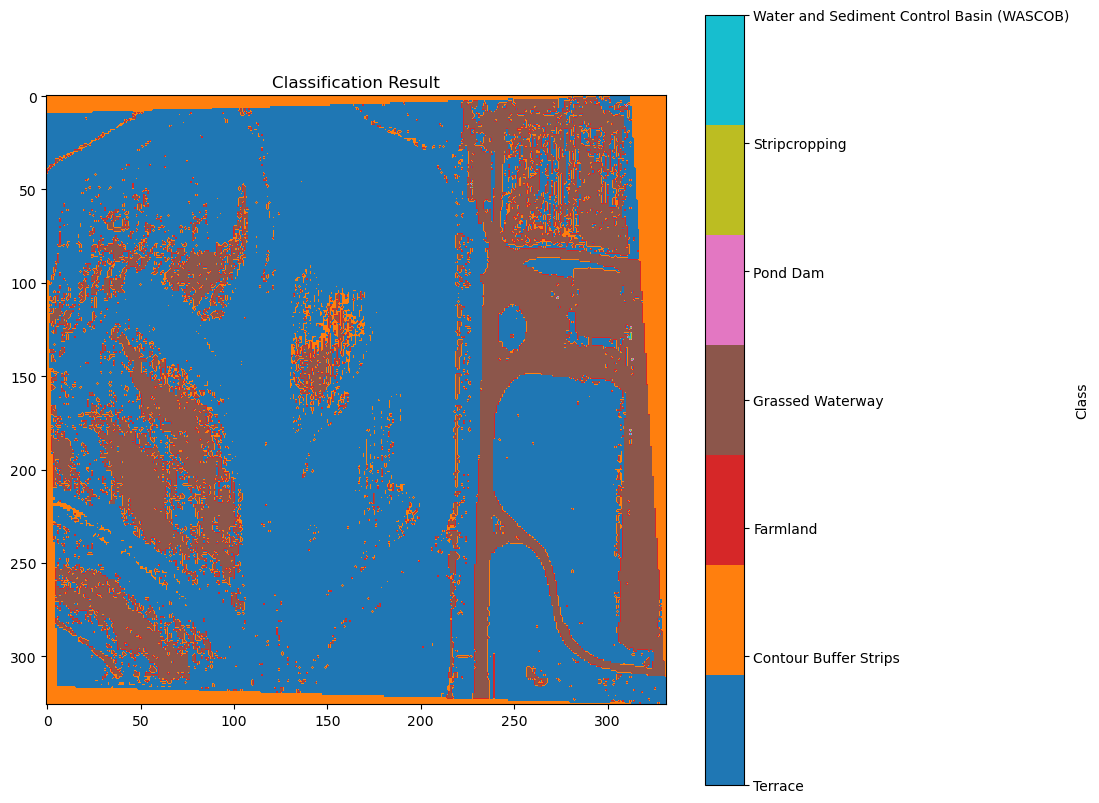

In [126]:
# Plot using tab10 colormap for discrete colors
tab10_custom = plt.get_cmap('tab10', 7)

# Plot using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(classified_labels_numeric, cmap=tab10_custom, vmin=1, vmax=7)  # Specify vmin and vmax to ensure correct mapping
cbar = plt.colorbar(ticks=range(1, 8), label='Class')  # Specify ticks for discrete classes
cbar.ax.set_yticklabels(class_mapping.keys())  # Set custom tick labels for the colorbar
plt.title('Classification Result')
plt.show()

In [16]:
#Georgia NAIP example

'''
NAIP 4-band image band designations (downloaded from USGS EarthExplorer):

Band 1: red
Band 2: green
Band 3: blue
Band 4: nir

'''

xx = rasterio.open("F:/Iowa BMP/Geotiffs/GA/Tests/m_3108101_se_17_060_20220130.tif")

print('bands: ' + str(xx.count))
print('height: ' + str(xx.height))
print('width: ' + str(xx.width))
print('crs: ' + str(xx.crs))



bands: 4
height: 12290
width: 10620
crs: EPSG:26917


In [103]:
##Add NDVI and NDWI
# Open the existing GeoTIFF file in read mode
with rasterio.open("F:/Iowa BMP/Geotiffs/GA/Tests/m_3108101_se_17_060_20220130.tif") as src:
    # Read the red and near-infrared bands
    red_band = src.read(1)  
    green_band = src.read(2)  
    blue_band = src.read(3)  
    nir_band = src.read(4)  

    # Calculate NDVI -- SOME INF VALUES, BELOW IS HOW TO DEAL WITH THEM?
    ndvi = np.where((nir_band + red_band) == 0, 0, (nir_band - red_band) / (nir_band + red_band))
    ndwi = np.where((green_band + nir_band) == 0, 0, (green_band - nir_band) / (green_band + nir_band))

    # Get metadata from the source file
    kwargs = src.meta

    # Update metadata for the new band
    kwargs.update(
        count=len(src.indexes) + 2,  # Increment band count
        dtype=rasterio.float32  # Specify data type (float32 for NDVI and NDWI)
    )

    # Open a new GeoTIFF file in write mode
    with rasterio.open("F:/Iowa BMP/Geotiffs/GA/Tests/m_3108101_se_17_060_20220130_with_ndvi6.tif", "w", **kwargs) as dst:
        # Write the existing bands to the new file
        for i in range(1, len(src.indexes) + 1):
            dst.write(src.read(i), i)

        # Write the NDVI band to the new file
        dst.write(ndvi.astype(rasterio.float32), len(src.indexes) + 1)

C:\Users\arj26323\AppData\Local\Temp\ipykernel_2124\4184468446.py:11: RuntimeWarning: divide by zero encountered in divide
  ndvi = np.where((nir_band + red_band) == 0, 0, (nir_band - red_band) / (nir_band + red_band))
C:\Users\arj26323\AppData\Local\Temp\ipykernel_2124\4184468446.py:11: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir_band + red_band) == 0, 0, (nir_band - red_band) / (nir_band + red_band))
C:\Users\arj26323\AppData\Local\Temp\ipykernel_2124\4184468446.py:12: RuntimeWarning: divide by zero encountered in divide
  ndwi = np.where((green_band + nir_band) == 0, 0, (green_band - nir_band) / (green_band + nir_band))
C:\Users\arj26323\AppData\Local\Temp\ipykernel_2124\4184468446.py:12: RuntimeWarning: invalid value encountered in divide
  ndwi = np.where((green_band + nir_band) == 0, 0, (green_band - nir_band) / (green_band + nir_band))


In [104]:
##Divide by zero errors
print('bands: ' + str(dst.count))
print('height: ' + str(dst.height))
print('width: ' + str(dst.width))
print('crs: ' + str(dst.crs))

im2 = rasterio.open("F:/Iowa BMP/Geotiffs/GA/Tests/m_3108101_se_17_060_20220130_with_ndvi6.tif", "r")

dst_whole = np.column_stack((im2.read(3).ravel(), im2.read(2).ravel(), im2.read(1).ravel(), im2.read(4).ravel(), \
                           im2.read(5).ravel(), im2.read(6).ravel())) ##NOTE BAND DIFFERENCES

classified_dst = pipe.predict(dst_whole)
classified_dst_reshaped = classified_dst.reshape(im2.read(1).shape)

class_mapping = {
    'Terrace': 1,
    'Contour Buffer Strips': 2, 
    'Farmland': 3,
    'Grassed Waterway': 4, 
    'Pond Dam': 5, 
    'Stripcropping': 6,
    'Water and Sediment Control Basin (WASCOB)': 7
}

classified_dst_numeric = np.vectorize(class_mapping.get)(classified_dst_reshaped)

bands: 6
height: 12290
width: 10620
crs: EPSG:26917


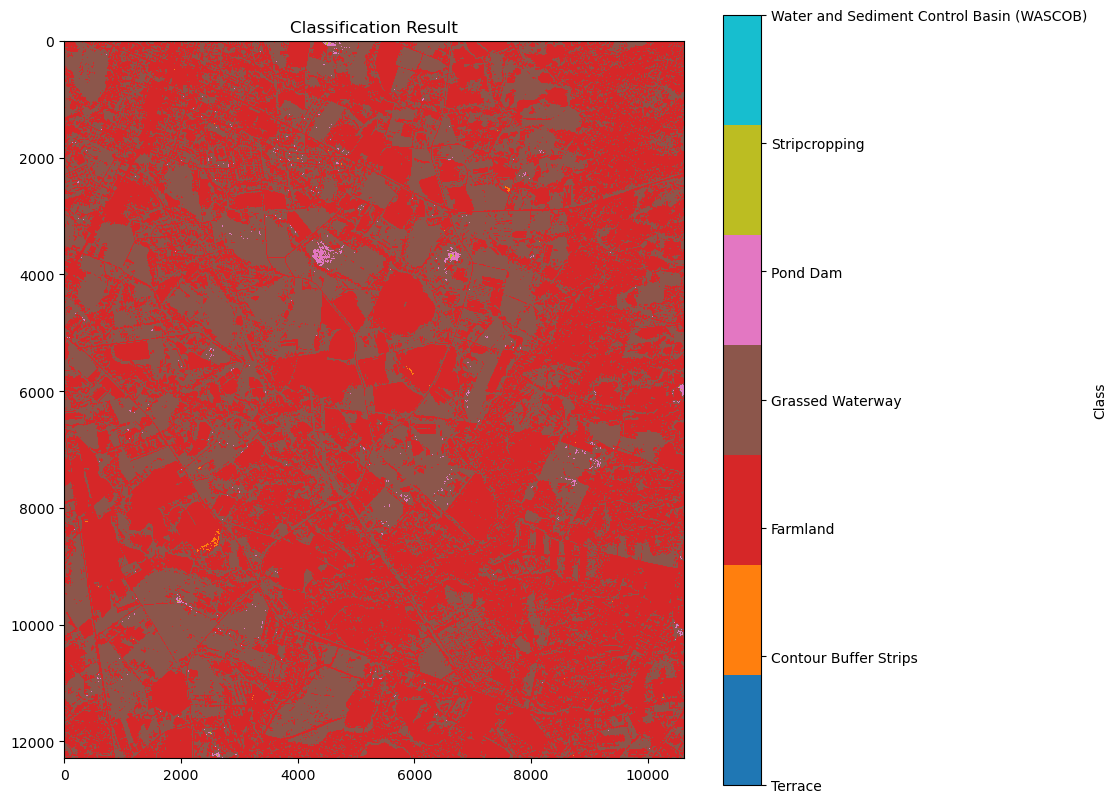

In [105]:
# Plot using tab10 colormap for discrete colors
tab10_custom = plt.get_cmap('tab10', 7)

# Plot using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(classified_dst_numeric, cmap=tab10_custom, vmin=1, vmax=7)  # Specify vmin and vmax to ensure correct mapping
cbar = plt.colorbar(ticks=range(1, 8), label='Class')  # Specify ticks for discrete classes
cbar.ax.set_yticklabels(class_mapping.keys())  # Set custom tick labels for the colorbar
plt.title('Classification Result')
plt.show()

In [ ]:
'''
Ideas to improve BMP classification:

Weighted Loss Function: Adjust the loss function to penalize misclassifications of the minority class more heavily, 
effectively giving it more importance during training.

Adjusting Class Weights: In some machine learning algorithms (such as Random Forest), 
you can specify class weights to give more importance to minority classes during training.

A possible approach could be to allocate a larger proportion of the training dataset to BMPs while still 
including enough samples of general farmland to maintain the overall class distribution. Experiment with different 
ratios and evaluate the model performance using appropriate metrics such as precision, recall, and F1-score to find the
optimal balance between class representation and classification accuracy for your specific use case. 
Cross-validation techniques can also help assess the robustness of your model across different subsets of the data.

How to detect BMPs as opposed to just row crops, fields, etc.?
'''